In [2]:
!conda env export > sql.yml

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sqlite3
import pandas as pd
from utils import *

### Импортируем базу данных

In [5]:
conn = sqlite3.connect('trade_info.sqlite3')
chart_data = pd.read_sql('SELECT id, time, lot_size, session_id, deal_id, price FROM chart_data', conn)
trading_session = pd.read_sql('SELECT id, date, trading_type, platform_id FROM trading_session', conn)

```Deal_id – номер договора. Некоторые сделки дублируются, реальная сделка – та, что встречается раньше всех среди всех с одним deal_id```: Выбросим dummy-сделки из списка


In [6]:
chart_data = chart_data.drop_duplicates(subset=['deal_id'], keep='first')

In [7]:
chart_data.head()

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279


In [8]:
trading_session.head()

,id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2


### Объединим 2 таблицы в единую, используя session_id

In [9]:
new_df = tables_union(chart_data, trading_session)
new_df.head()

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-03 11:34:47,0,2,12,0,-0.235500,daily,2.0
2019-10-01 11:32:37,1,2,13,1,-0.235500,daily,2.0
2019-10-01 11:52:45,2,13,13,2,-0.303677,daily,2.0
2019-10-01 11:53:07,3,25,13,3,-0.303677,daily,2.0
2019-10-01 12:00:43,4,124,13,4,-0.364279,daily,2.0


### 4 вида сессий

Вспомним, что у нас есть 2 площадки и 2 типа торгов. Разделим все сессии на 4 типа:

```
platform_id == 1 & trading_type == daily
platform_id == 1 & trading_type == monthly
platform_id == 2 & trading_type == daily
platform_id == 2 & trading_type == monthly
```

Также, проверим, что каждая сессия лежит только в одном из 4х типов торгов

In [10]:
plat1_day, plat1_month, plat2_day, plat2_month = separate_types(new_df) ###проверить сортировку
plat1_day.head()

Никакая из сессий не принадлежит одновременно хотя бы 2м типам


,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-18 11:00:27,9,1,21,9,0.029634,daily,1.0
2019-10-18 11:02:23,10,36,21,10,0.029634,daily,1.0
2019-10-18 11:02:23,11,29,21,11,0.029634,daily,1.0
2019-10-18 11:02:23,12,18,21,12,0.029634,daily,1.0
2019-10-18 11:03:07,13,150,21,13,0.029634,daily,1.0


### Перефоматируем таблицы: объединим все сделки внутри сессии

Отсорируем сделки внутри каждой сессии по времени. Проверим, что никакая сессия не длилась более 1 дня. 

Также добавим новые признаки для каждой сессии:

- ```date``` - дата проведения сессии

- ```first_deal``` - время первой сделки

- ```last_deal``` - время последней сделки

- ```delta``` - прошедшее время между первой и последней сделкой

- ```deal_count``` - кол-во сделок за сессию

- ```total_size``` - суммарный объем всех сделок за сессию

- ```avg_price``` - средневзвешенная цена за сессию (взвешиваем по объему)

- ```start_price``` - стартовая цена: средневзвешенная цена с прошлой сессии


### Добавим точные границы сессий

Чтобы нарисовать графики сессий для сравнения, необходимо установить точные границы каждой торговой сессии. Мы знаем, что месячные торги длятся 60 минут, а суточные торги - 30 минут. Судя по данным, месячные торги идут в основном с 11:00:00 до 12:00:00. Однако, встречаются вхождения, где последняя сделка заключена между 12:00:00 и 12:01:00, причем в некоторых сессиях эта сделка проходит по цене, отличной от цены на интервале [11:59:00, 12:00:00]. То же самое можно заметить и в суточных торгах. [На сайте биржы](https://spimex.com/markets/gas/trades/schedule/) в расписании есть следующая пометка:

```* - время начала и время окончания торговых сессий находится в пределах указанного времени с точностью до одной минуты.```

Поэтому будем рисовать график каждой сессии так, что в нем будет 61 минута, если это месячные торги, либо 31 минута, если это суточные торги. Добавим новые признаки в таблицу:

- ```start``` - начало сессии: округленное к началу часа время первой сделки

- ```end``` - конец сессии: ```start``` + 61 (31) минута. Если же время последней сделки превышает данный показатель, то установим его как округленное к концу часа время последней сделки

- ```full_delta``` - длина сессии: разница между ```end``` и ```start```

- ```session_type``` - типичная или нетипичная сессия: типичная сессия длится 61 (31) минуту

- вспомогательные признаки для построения графиков: ```xxs```, ```yys```, ```from_start```

In [11]:
sess_plat1_month = groupby_session_id(plat1_month)
sess_plat2_month = groupby_session_id(plat2_month)
sess_plat1_day = groupby_session_id(plat1_day)
sess_plat2_day = groupby_session_id(plat2_day)

sess_plat1_month.head()

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,...,full_delta,session_type,deal_count,total_size,avg_price,last_price,start_price,xxs,yys,from_start
0,35,[2019-02-21T11:05:02.000000000],[1114],[1],[688],[-0.7354659067511725],monthly,1.0,2019-02-21,11:05:02,...,0 days 01:01:00,typical,1,1,-0.735466,-0.735466,-0.735466,"[2019-02-21T11:00:00.000000000, 2019-02-21T11:...","[-0.7354659067511725, -0.7354659067511725, -0....","[0, 5, 61]"
1,39,"[2019-03-22T11:05:02.000000000, 2019-03-22T11:...","[927, 928, 926, 929, 930, 931, 932, 933, 934, ...","[16, 4, 17, 1, 150, 500, 41, 7, 2, 450, 150, 5...","[648, 649, 647, 650, 651, 652, 653, 654, 655, ...","[-0.7657668914107529, -0.7657668914107529, -0....",monthly,1.0,2019-03-22,11:05:02,...,0 days 02:01:00,untypical,147,9646,-1.060704,-1.182405,-0.735466,"[2019-03-22T11:00:00.000000000, 2019-03-22T11:...","[-0.7354659067511725, -0.7657668914107529, -0....","[0, 5, 5, 5, 6, 19, 22, 33, 33, 33, 35, 38, 38..."
2,37,"[2019-04-23T11:34:25.000000000, 2019-04-23T11:...","[623, 621, 624, 622, 620, 625, 626, 627, 628, ...","[48, 302, 2, 50, 1, 120, 6, 600, 5, 1, 1, 557,...","[395, 393, 396, 394, 392, 397, 398, 399, 400, ...","[-0.7657668914107529, -0.7278906605862775, -0....",monthly,1.0,2019-04-23,11:34:25,...,0 days 01:01:00,typical,51,4244,-0.785851,-0.909697,-1.060704,"[2019-04-23T11:00:00.000000000, 2019-04-23T11:...","[-1.0607035957118103, -0.7657668914107529, -0....","[0, 34, 34, 34, 34, 34, 34, 37, 37, 38, 38, 38..."
3,41,"[2019-08-23T11:01:06.000000000, 2019-08-23T11:...","[1117, 1116, 1119, 1118, 1120, 1126, 1125, 112...","[1, 8, 13, 3, 1, 1, 1, 1, 25, 469, 3, 31, 33, ...","[691, 690, 693, 692, 694, 700, 699, 698, 697, ...","[-0.04611850574571931, -0.04611850574571931, -...",monthly,1.0,2019-08-23,11:01:06,...,0 days 01:01:00,typical,57,2914,-0.049891,-0.083995,-0.785851,"[2019-08-23T11:00:00.000000000, 2019-08-23T11:...","[-0.7858509323738536, -0.04611850574571931, -0...","[0, 1, 1, 1, 1, 3, 11, 11, 11, 11, 11, 11, 12,..."
4,30,"[2019-09-23T11:03:17.000000000, 2019-09-23T11:...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[5, 95, 34, 1, 1, 2, 2, 19, 12, 1, 1, 1, 1, 1,...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[0.10538641755218249, 0.10538641755218249, 0.1...",monthly,1.0,2019-09-23,11:03:17,...,0 days 01:01:00,typical,67,3177,0.028971,-0.030968,-0.049891,"[2019-09-23T11:00:00.000000000, 2019-09-23T11:...","[-0.04989053120394264, 0.10538641755218249, 0....","[0, 3, 3, 4, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


### Нетипичные сессии

Проверим нетипичные сессии по признаку ```session_type```, чтобы в дальнейшем исключить их кластерного анализа

#### Месячные торги: площадка 1

Сессия от 2019-03-22 длилась 2 часа. Кол-во сделок и суммарный объем сделок намного больше, чем у остальных сессий в той же группе. Много сделок произошло во втором часе.

Untypical_sessions:

      date | first_dl last_dl | cnt | total size
2019-03-22 | 11:05:02  12:58:12 | 147 | 9646




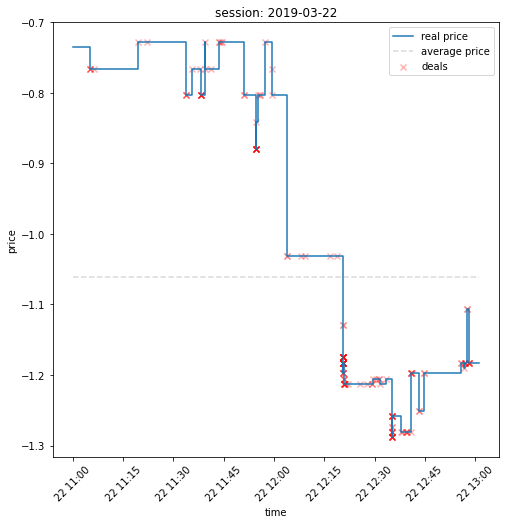

In [12]:
separate_sessions(sess_plat1_month)

dates = [datetime.date(2019, 3, 22)]
sessions_by_date(sess_plat1_month, dates, figsize=8)

#### Месячные торги: площадка 2

Нетипичных сделок нет

In [13]:
separate_sessions(sess_plat2_month)

Untypical_sessions:

      date | first_dl last_dl | cnt | total size




#### Суточные торги: площадка 1

4 нетипичные сессии, которые продлились более 30 минут. Везде кол-во сделок, совершенных после 30 минуты равно 1, поэтому непонятно, как оценивать такие данные: как ошибку с маркировке последней сессии или как реальные данные.

Untypical_sessions:

      date | first_dl last_dl | cnt | total size
2021-04-26 | 11:00:36  11:32:14 |   2 |  701
2021-03-09 | 11:00:20  11:37:30 |   4 |  107
2021-05-21 | 11:00:14  11:42:59 |   4 |  361
2020-02-10 | 11:03:36  17:08:18 |   5 |  563




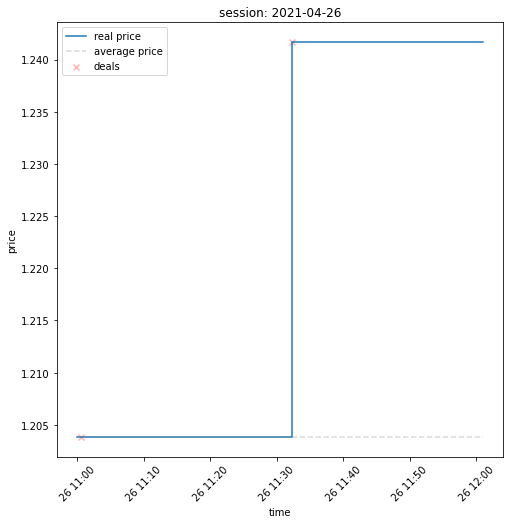

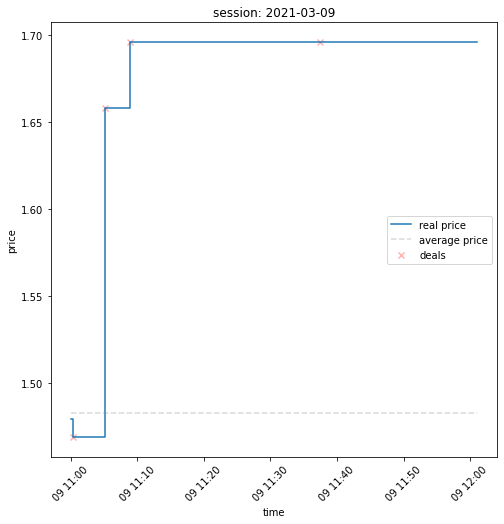

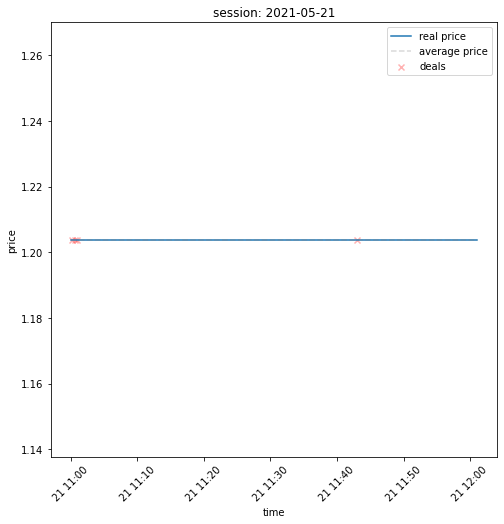

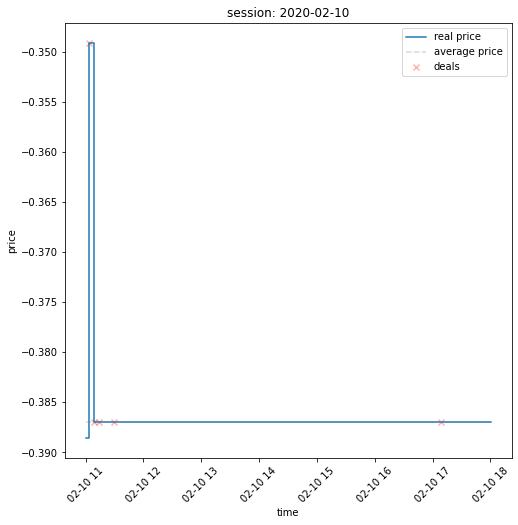

In [14]:
separate_sessions(sess_plat1_day)

dates_3 = [datetime.date(2021, 4, 26),
           datetime.date(2021, 3, 9),
           datetime.date(2021, 5, 21),
           datetime.date(2020, 2, 10)]

sessions_by_date(sess_plat1_day, dates_3, figsize=8)

#### Суточные торги: площадка 2

аналогично пред пункту

Untypical_sessions:

      date | first_dl last_dl | cnt | total size
2020-05-14 | 11:29:52  11:35:02 |   6 |  140
2021-04-13 | 11:56:38  12:03:42 |  11 |  316




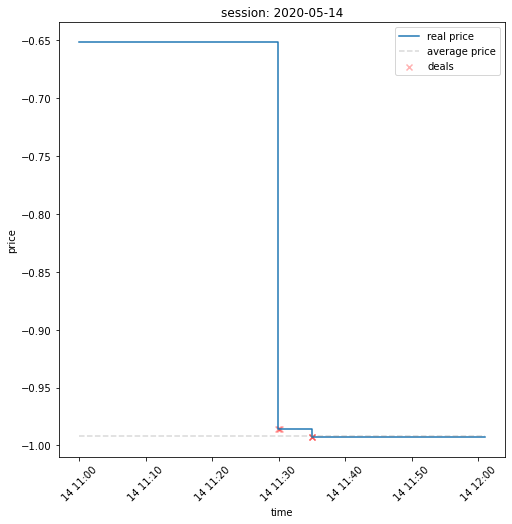

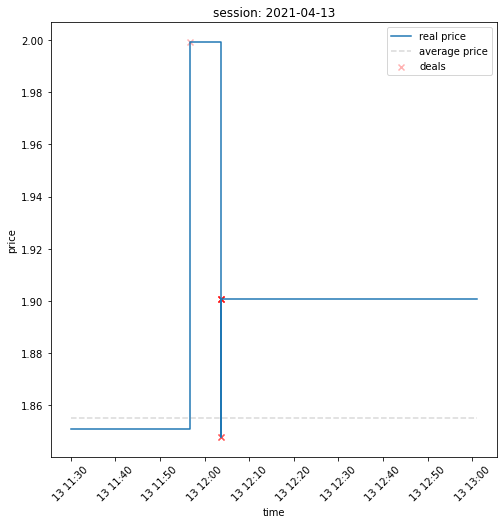

In [15]:
separate_sessions(sess_plat2_day)

dates_4 = [datetime.date(2020, 5, 14),
           datetime.date(2021, 4, 13)]

sessions_by_date(sess_plat2_day, dates_4, figsize=8)

### История

Построим графики цен за все несколько лет для каждого из 4-х типов торгов. На первый взгляд графики выглядят логично: для месячных торгов, сделки сосредоточенны в днях, с интервалом примерно 1 месяц; сделки по суточным торгам сосредоточенны в группах.

In [16]:
history_list = [sess_plat1_month, sess_plat2_month, sess_plat1_day, sess_plat2_day]

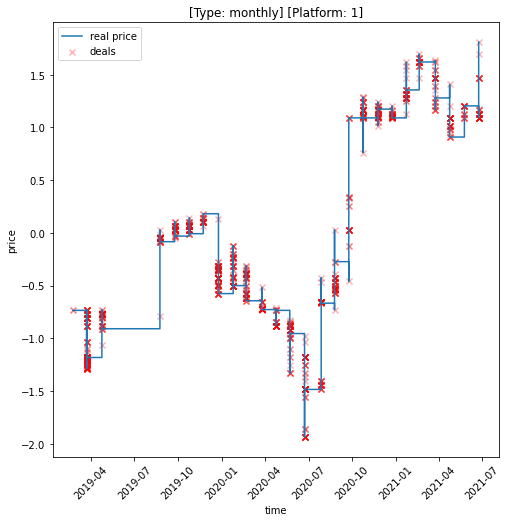

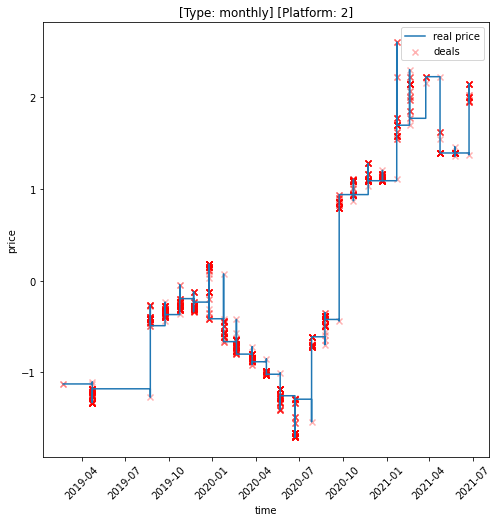

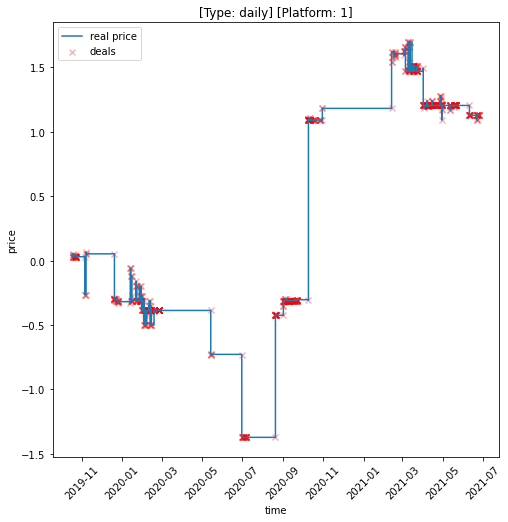

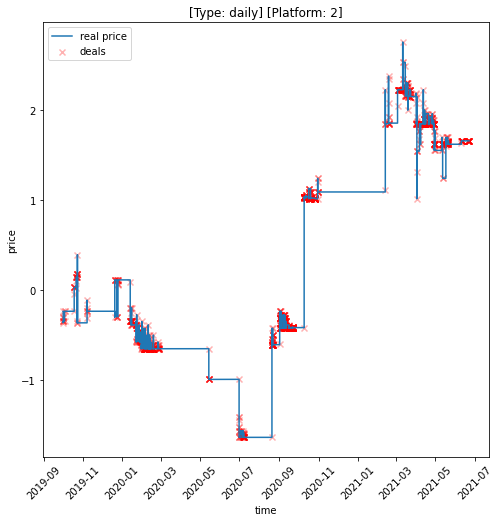

In [17]:
for history in history_list:
    global_trend(history, figsize=8)

Теперь детальнее посмотрим на тренд цен: визуализируем те же самые данные, но на этот раз выбросим все промежутки между сессиями (пунктиром обозначена средневзвешенная цена за сессию).

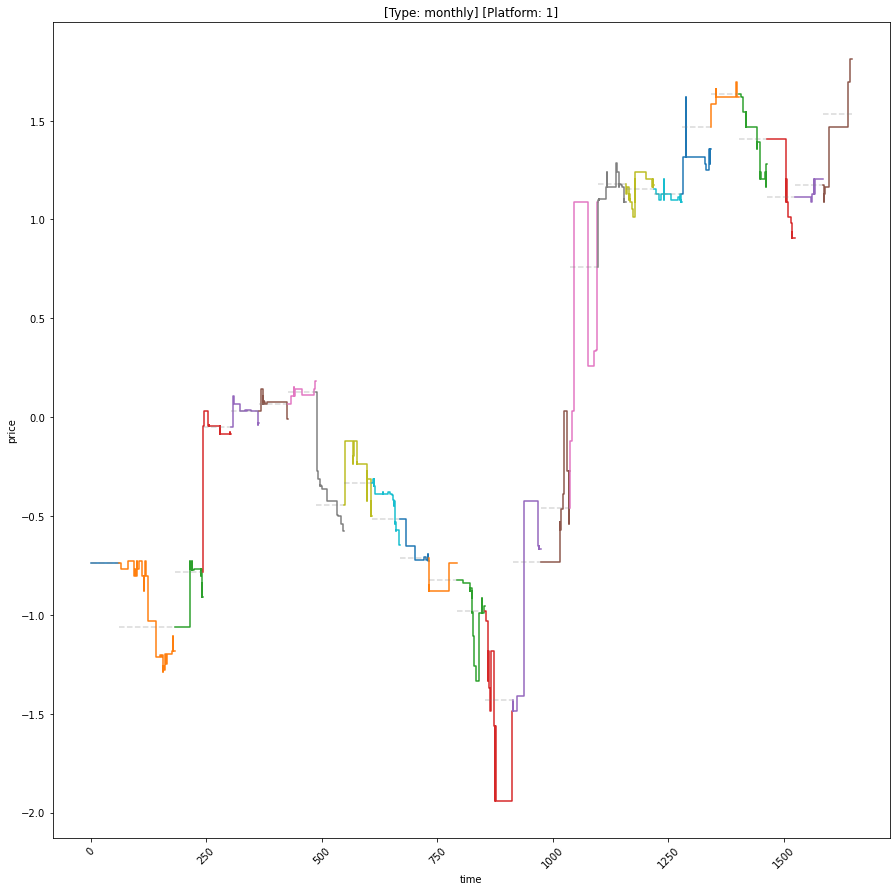

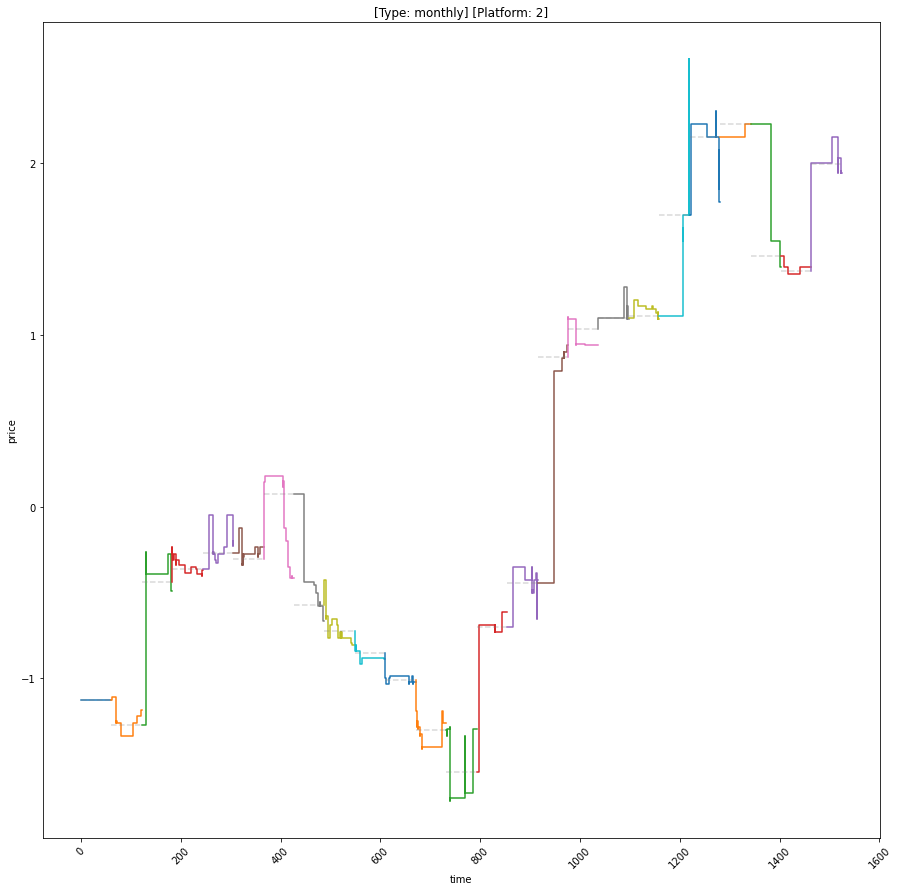

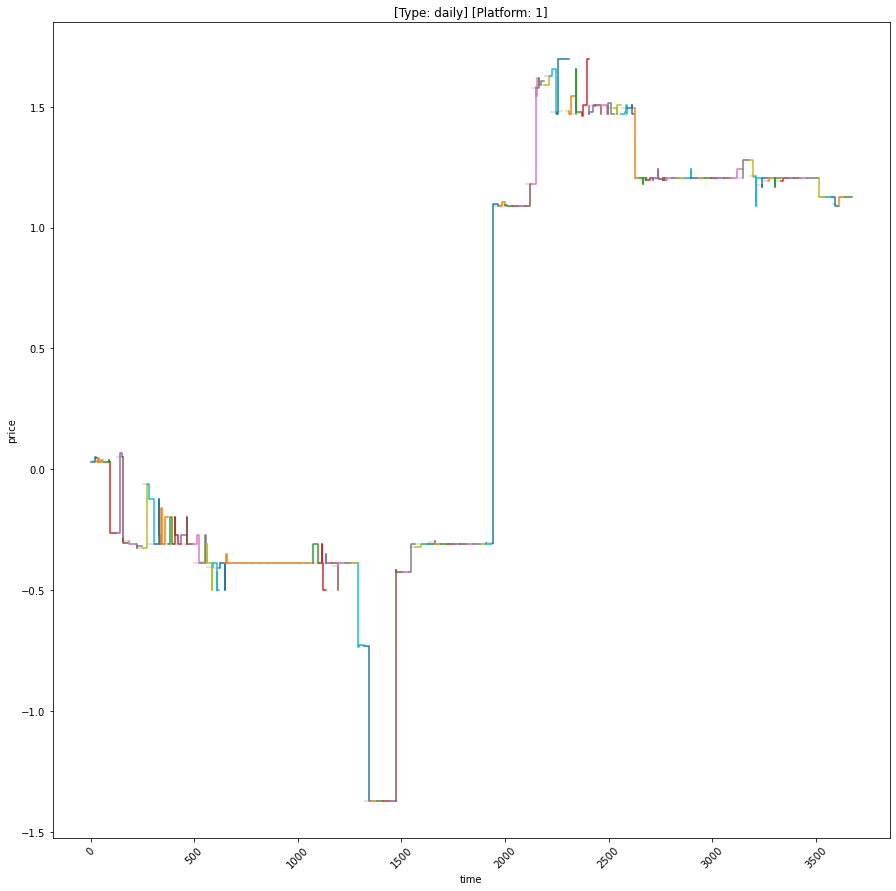

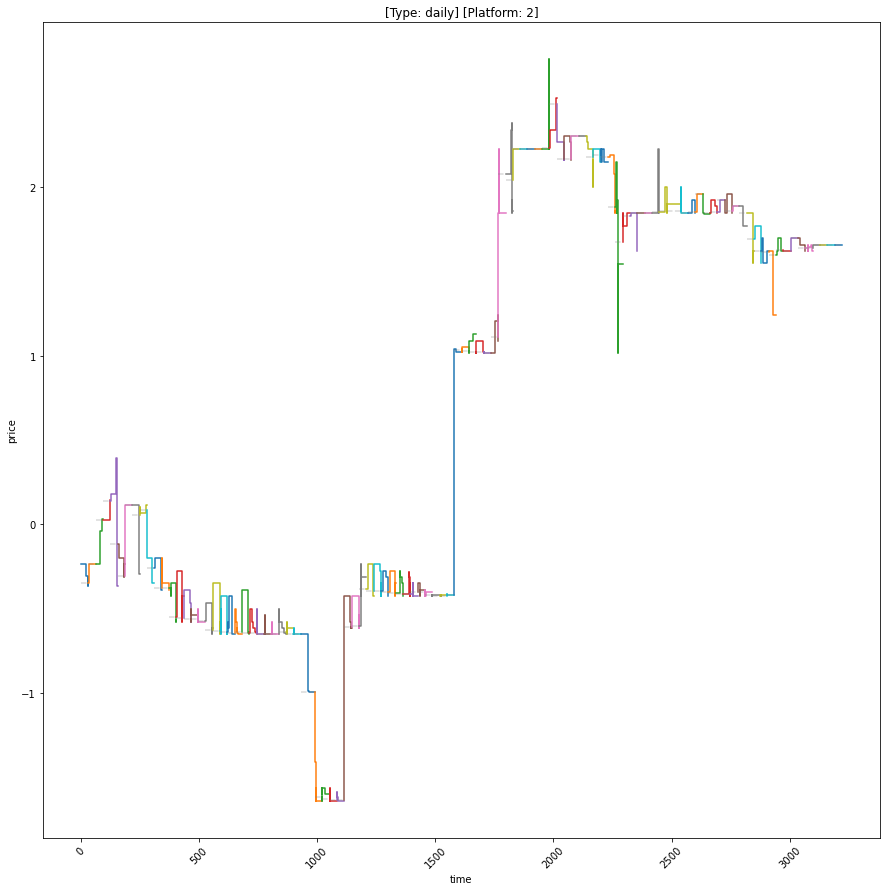

In [18]:
for history in history_list:
    global_trend_gaps(history, figsize=15)

### Кластерный анализ

1. Используем следующие метрики:
- DTW
- Cosine distance
- MAE

2. Кластерный анализ интересует нас с точки зрения предсказания средневзвешенной цены в каждую минуту сессии. 
Для использования MAE и Cosine distance, необходимы значения в фиксированных точках. В разных сессиях содержится разное кол-во сделок: каждую минуту может происходить сколь угодно много сделок. Поэтому, представим каждую сессию как 61-мерный (31-мерный) вектор, где каждая компонента соотвествует средневзвешенной цене на ближайшую минуту. Если в данную минуту не произошло ни одной сделки, то есть средневзвешенная цена равна 0, будем использовать средневзвешенную цену с предыдущей минуты (если в первую минуту сессии не произошло ни одно сделки, будем использовать средневзвешенную цену за прошлую сессию).


Новые признаки:

- ```avg_min_price``` - вектор

- ```norm_avg_min_price``` - нормированный вектор 

In [19]:
plat1_month = add_avg_min_price(sess_plat1_month)
plat2_month = add_avg_min_price(sess_plat2_month)
plat1_day = add_avg_min_price(sess_plat1_day)
plat2_day = add_avg_min_price(sess_plat2_day)

In [20]:
plat1_month.head()

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,...,deal_count,total_size,avg_price,last_price,start_price,xxs,yys,from_start,avg_min_price,norm_avg_min_price
0,35,[2019-02-21T11:05:02.000000000],[1114],[1],[688],[-0.7354659067511725],monthly,1.0,2019-02-21,11:05:02,...,1,1,-0.735466,-0.735466,-0.735466,"[2019-02-21T11:00:00.000000000, 2019-02-21T11:...","[-0.7354659067511725, -0.7354659067511725, -0....","[0, 5, 61]","[-0.7354659067511725, -0.7354659067511725, -0....","[-0.12803687993289598, -0.12803687993289598, -..."
1,39,"[2019-03-22T11:05:02.000000000, 2019-03-22T11:...","[927, 928, 926, 929, 930, 931, 932, 933, 934, ...","[16, 4, 17, 1, 150, 500, 41, 7, 2, 450, 150, 5...","[648, 649, 647, 650, 651, 652, 653, 654, 655, ...","[-0.7657668914107529, -0.7657668914107529, -0....",monthly,1.0,2019-03-22,11:05:02,...,147,9646,-1.060704,-1.182405,-0.735466,"[2019-03-22T11:00:00.000000000, 2019-03-22T11:...","[-0.7354659067511725, -0.7657668914107529, -0....","[0, 5, 5, 5, 6, 19, 22, 33, 33, 33, 35, 38, 38...","[-0.7354659067511725, -0.7354659067511725, -0....","[-0.0687883405979284, -0.0687883405979284, -0...."
2,37,"[2019-04-23T11:34:25.000000000, 2019-04-23T11:...","[623, 621, 624, 622, 620, 625, 626, 627, 628, ...","[48, 302, 2, 50, 1, 120, 6, 600, 5, 1, 1, 557,...","[395, 393, 396, 394, 392, 397, 398, 399, 400, ...","[-0.7657668914107529, -0.7278906605862775, -0....",monthly,1.0,2019-04-23,11:34:25,...,51,4244,-0.785851,-0.909697,-1.060704,"[2019-04-23T11:00:00.000000000, 2019-04-23T11:...","[-1.0607035957118103, -0.7657668914107529, -0....","[0, 34, 34, 34, 34, 34, 34, 37, 37, 38, 38, 38...","[-1.0607035957118103, -1.0607035957118103, -1....","[-0.1438890997926028, -0.1438890997926028, -0...."
3,41,"[2019-08-23T11:01:06.000000000, 2019-08-23T11:...","[1117, 1116, 1119, 1118, 1120, 1126, 1125, 112...","[1, 8, 13, 3, 1, 1, 1, 1, 25, 469, 3, 31, 33, ...","[691, 690, 693, 692, 694, 700, 699, 698, 697, ...","[-0.04611850574571931, -0.04611850574571931, -...",monthly,1.0,2019-08-23,11:01:06,...,57,2914,-0.049891,-0.083995,-0.785851,"[2019-08-23T11:00:00.000000000, 2019-08-23T11:...","[-0.7858509323738536, -0.04611850574571931, -0...","[0, 1, 1, 1, 1, 3, 11, 11, 11, 11, 11, 11, 12,...","[-0.7858509323738536, -0.04611850574571931, -0...","[-0.8548218086472383, -0.05016613567483692, -0..."
4,30,"[2019-09-23T11:03:17.000000000, 2019-09-23T11:...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[5, 95, 34, 1, 1, 2, 2, 19, 12, 1, 1, 1, 1, 1,...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[0.10538641755218249, 0.10538641755218249, 0.1...",monthly,1.0,2019-09-23,11:03:17,...,67,3177,0.028971,-0.030968,-0.049891,"[2019-09-23T11:00:00.000000000, 2019-09-23T11:...","[-0.04989053120394264, 0.10538641755218249, 0....","[0, 3, 3, 4, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[-0.04989053120394264, -0.04989053120394264, -...","[-0.12758428254479875, -0.12758428254479875, -..."


In [21]:
# Проверим, что мы используем именно расстояния, а не сходство 
check_distances()

vec1: [1, 1, 1], vec2: [2, 3, 4]

mae vec1-vec1: 0
mae vec1-vec2: 0.03509871864598457

mae vec1-vec1: 0.0
mae vec1-vec2: 2.0

dtw vec1-vec1: 0.0
dtw vec1-vec2: 3.7416573867739413


In [22]:
metrics = ['dtw', 'cos', 'mae']

### Кластеры

Для 4х типов торгов выведем сначала графики всех сессий вместе, а потом графики отдельных кластеров

#### Месячные торги: площадка 1

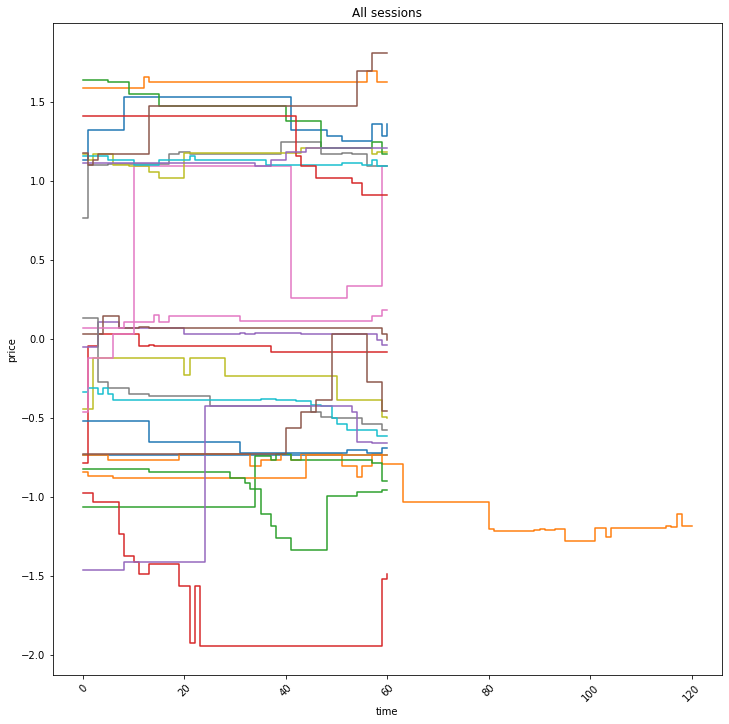

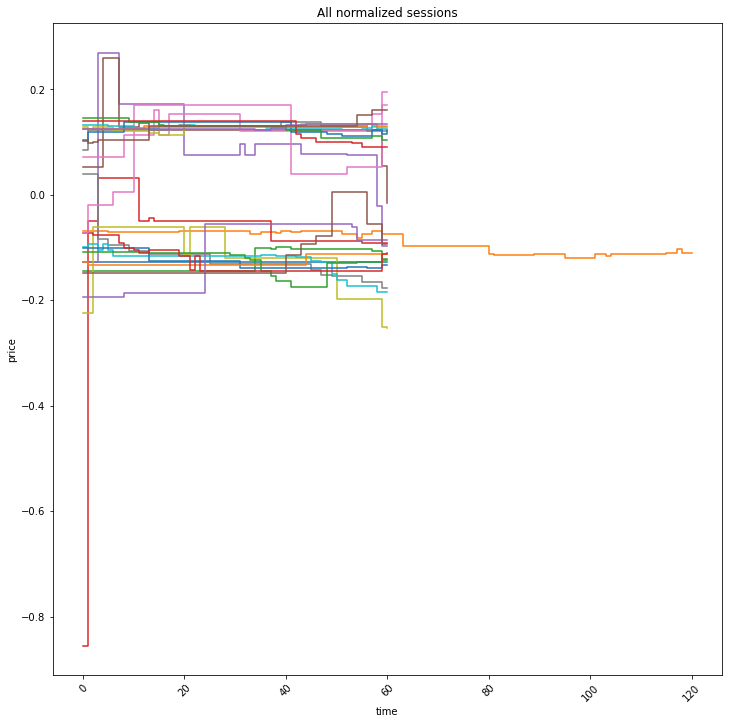

In [23]:
one_pic_all_binarized_sessions(plat1_month)

one_pic_all_binarized_sessions(plat1_month, normalize=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration

------------------------------ dtw ------------------------------


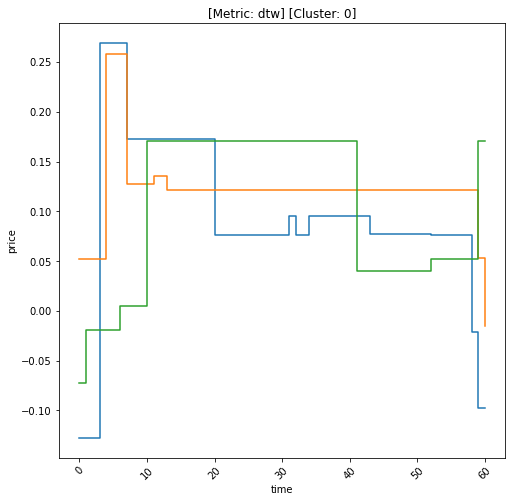

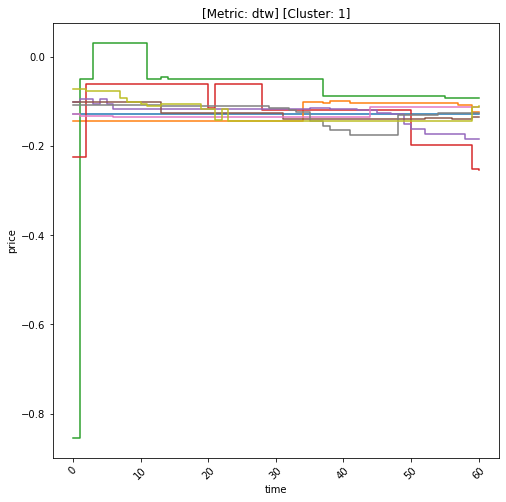

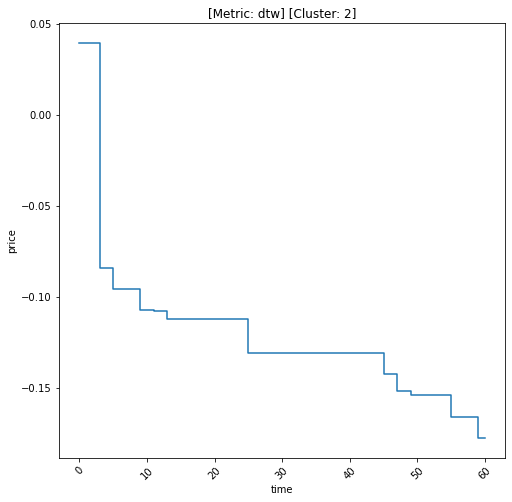

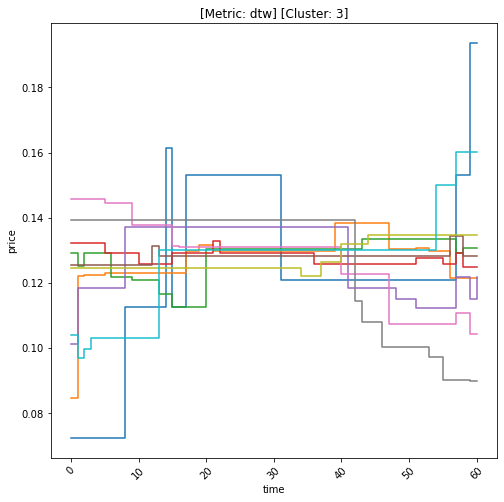

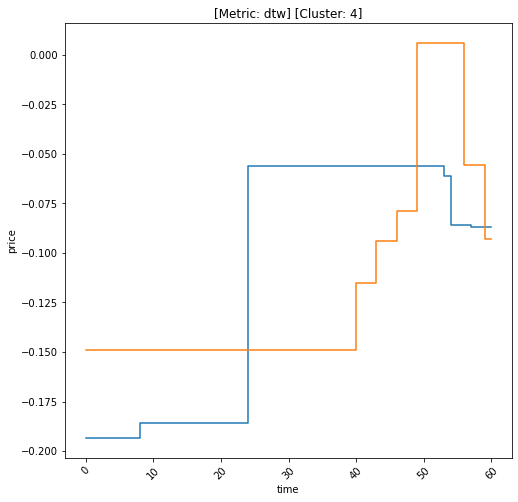


------------------------------ cos ------------------------------


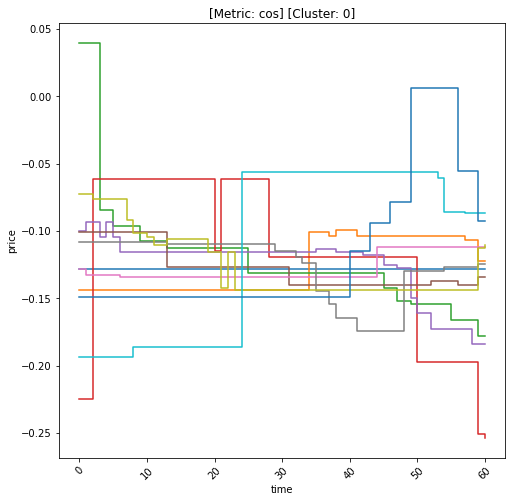

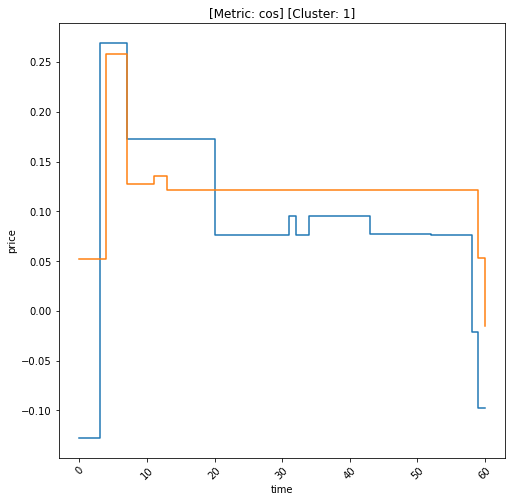

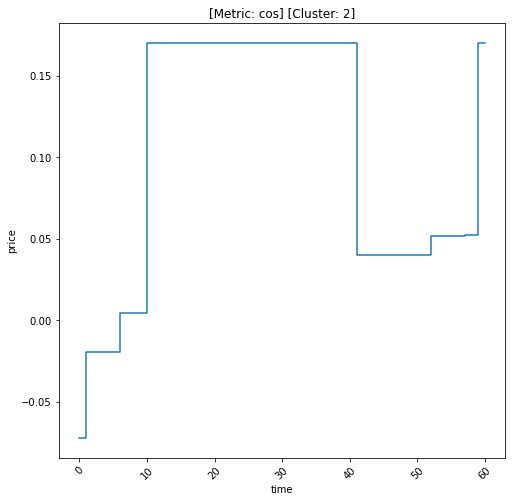

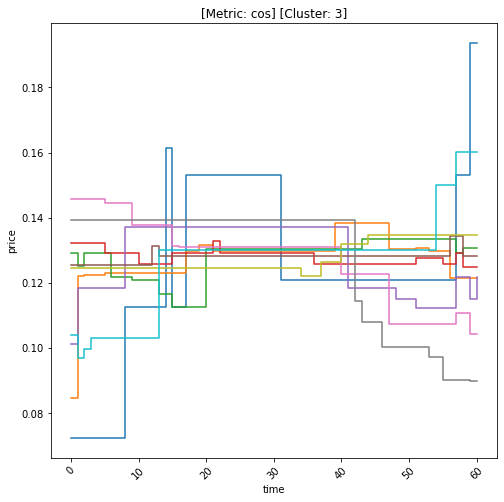

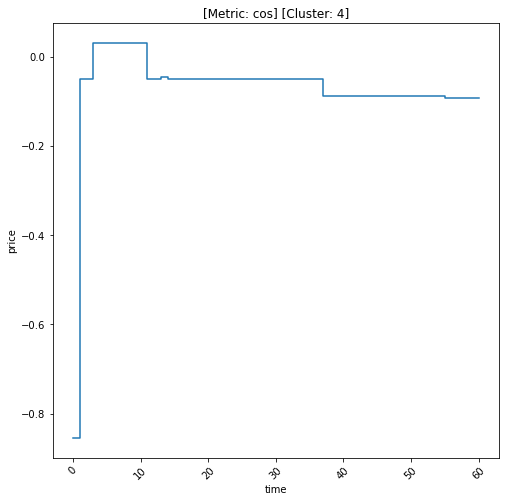


------------------------------ mae ------------------------------


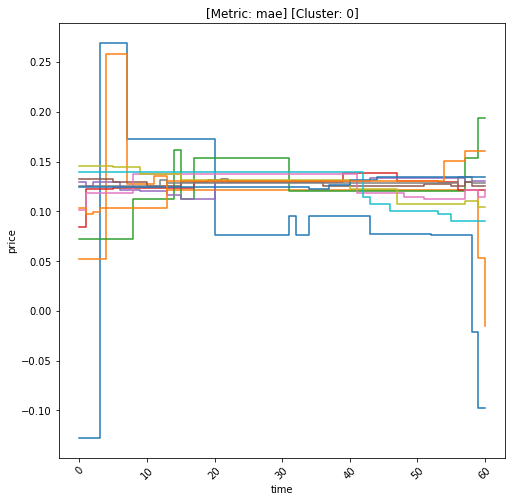

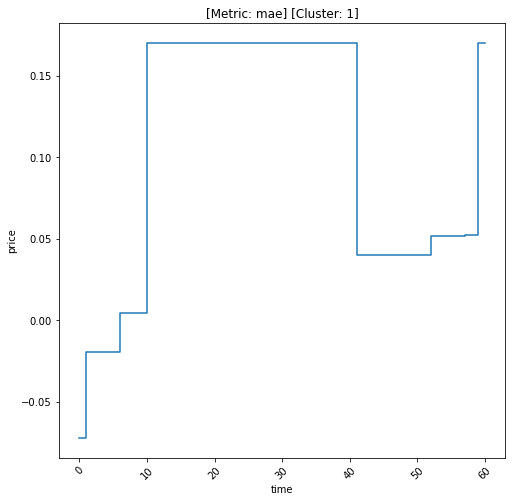

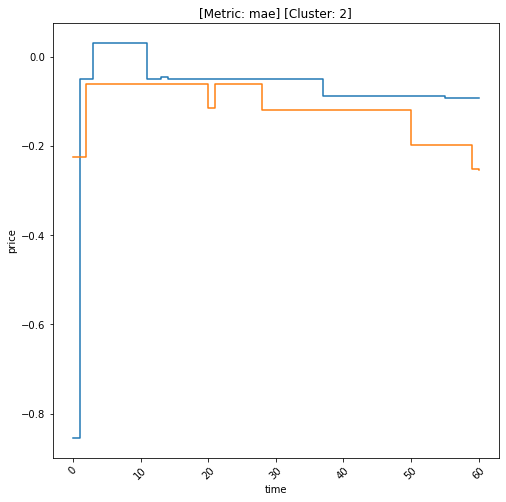

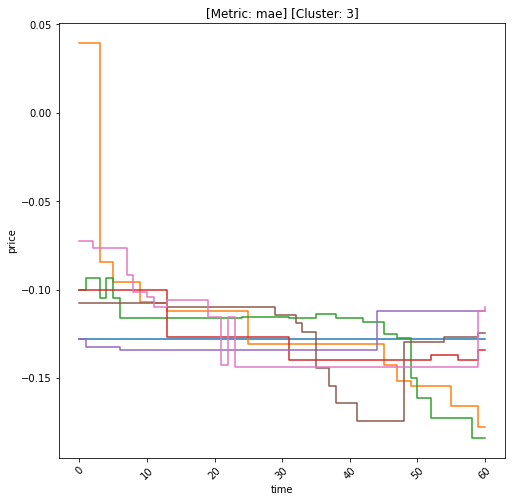

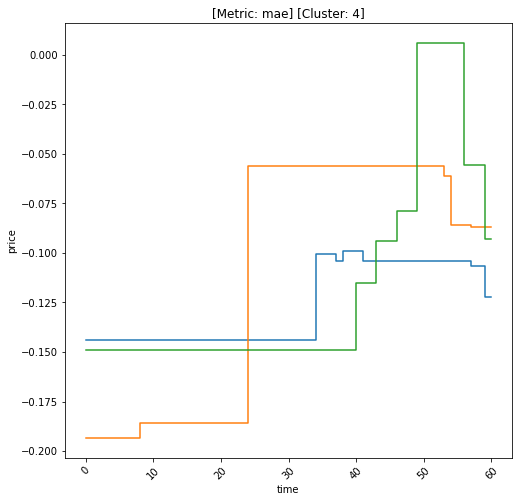

In [24]:
new_plat1_month = clusterize(plat1_month, num_means=5)
print()

for metric in metrics:
    print(f"{'-'*30} {metric} {'-'*30}")
    clustered_sessions(new_plat1_month, metric=metric, normalize=True, figsize=8)
    print()

#### Месячные торги: площадка 2

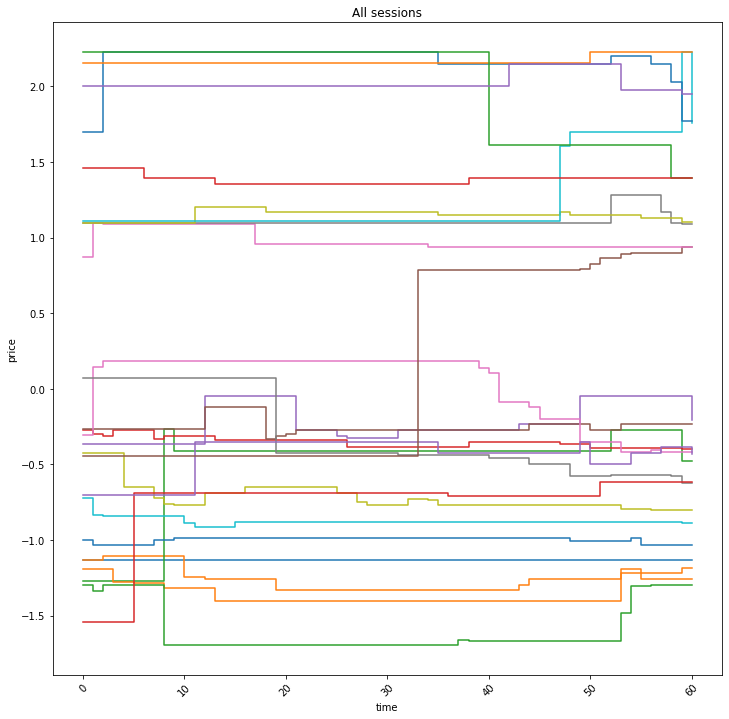

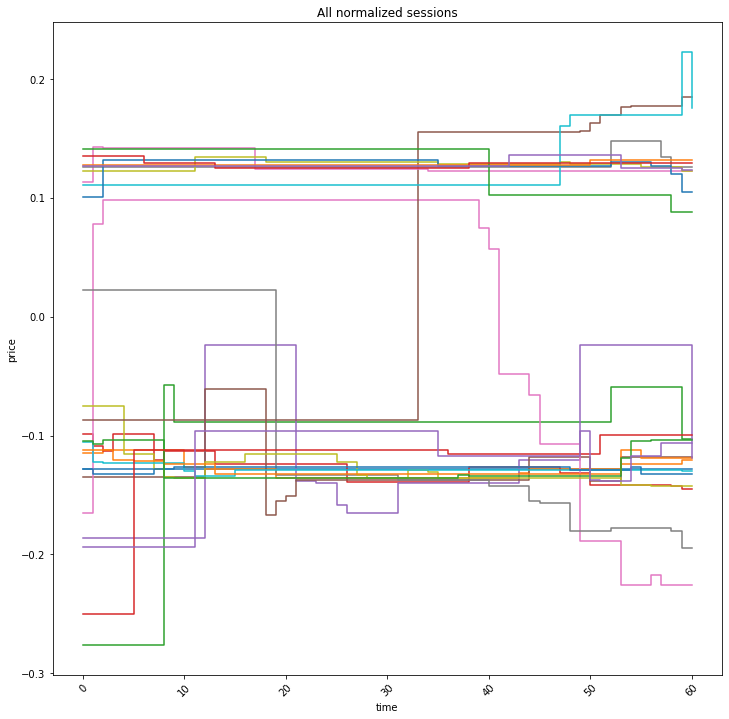

In [25]:
one_pic_all_binarized_sessions(plat2_month)

one_pic_all_binarized_sessions(plat2_month, normalize=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
k-means trial 0
iteration
iteration
iteration

------------------------------ dtw ------------------------------


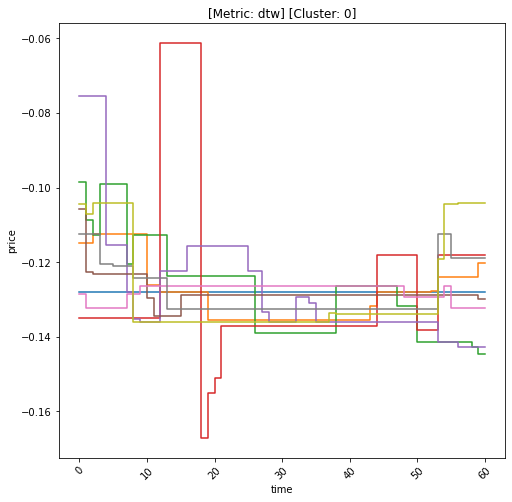

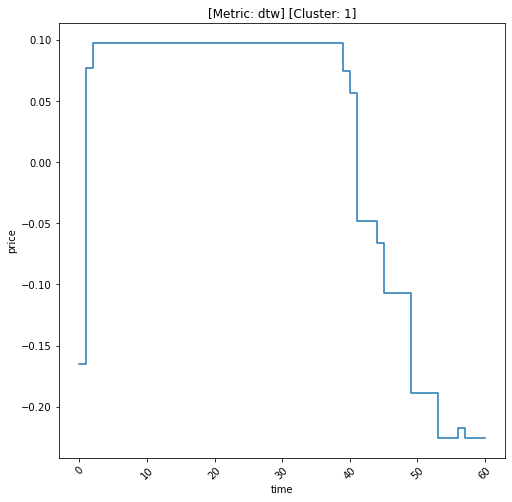

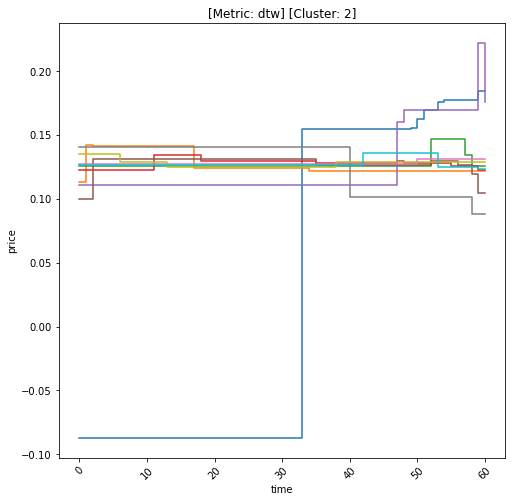

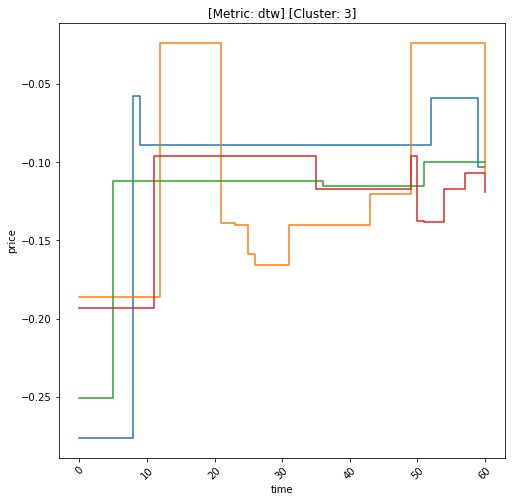

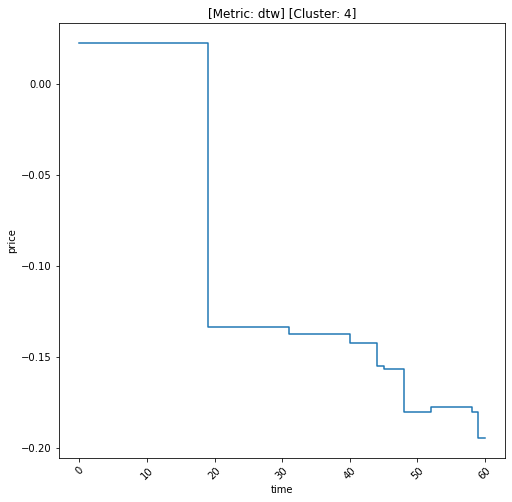


------------------------------ cos ------------------------------


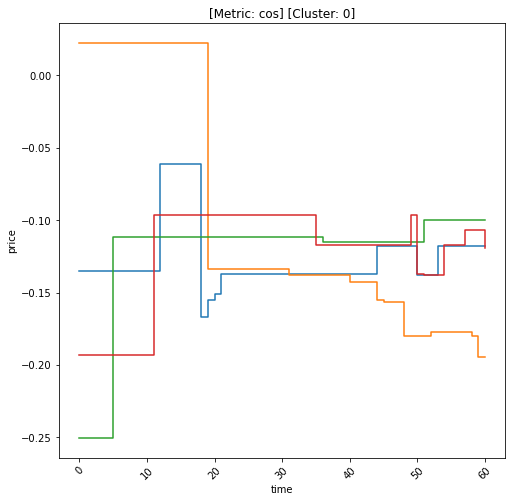

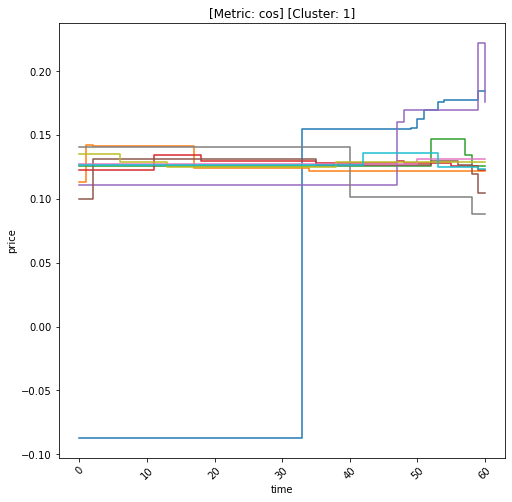

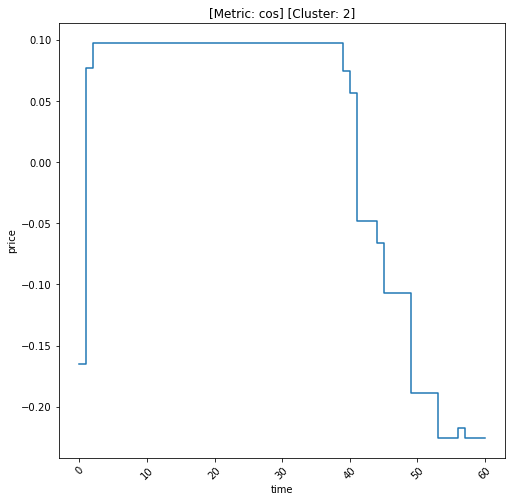

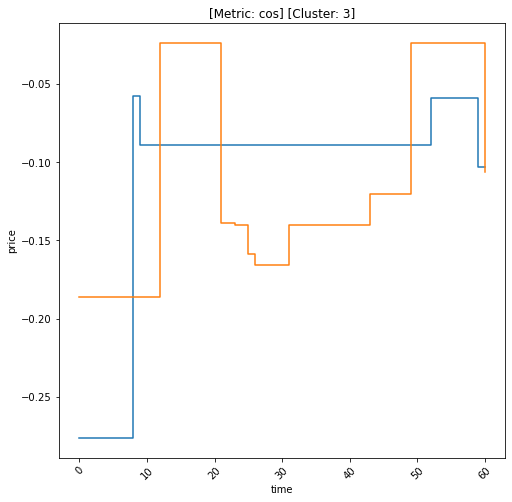

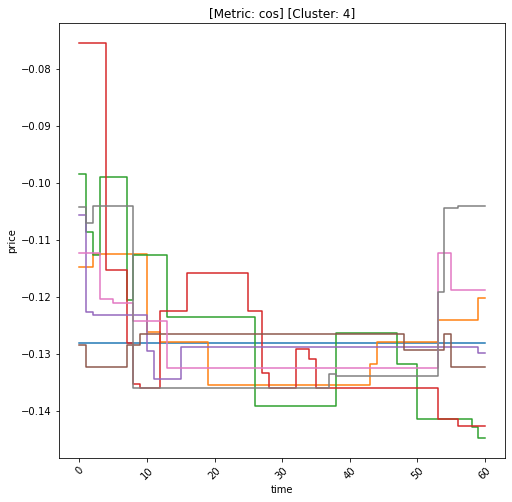


------------------------------ mae ------------------------------


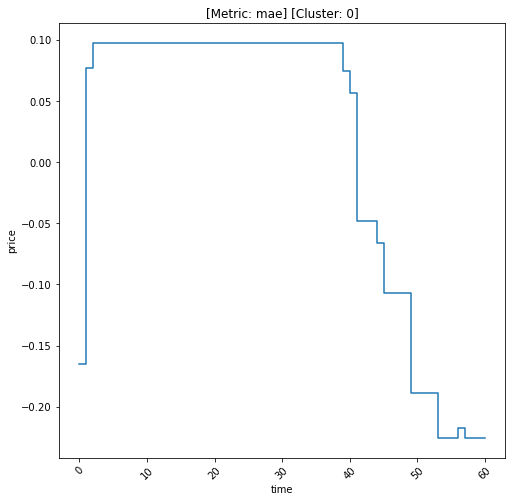

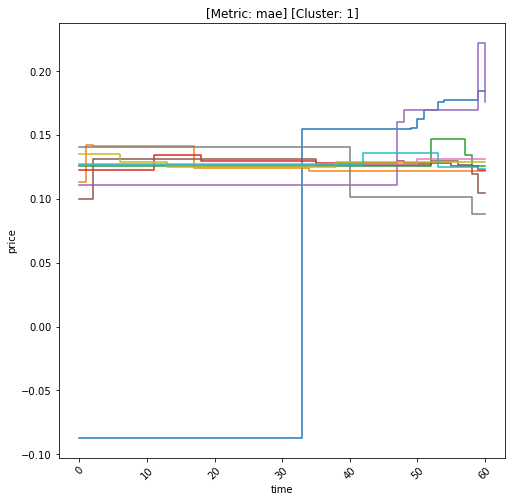

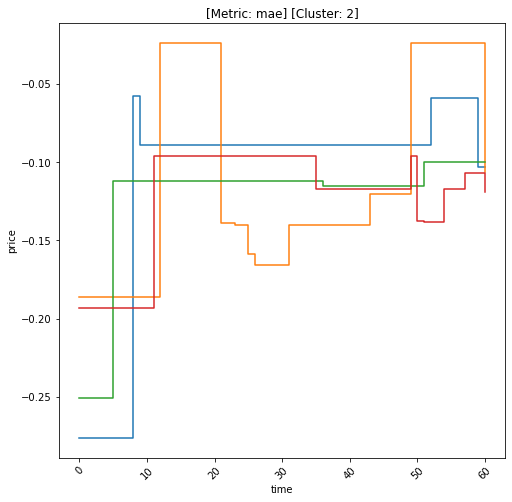

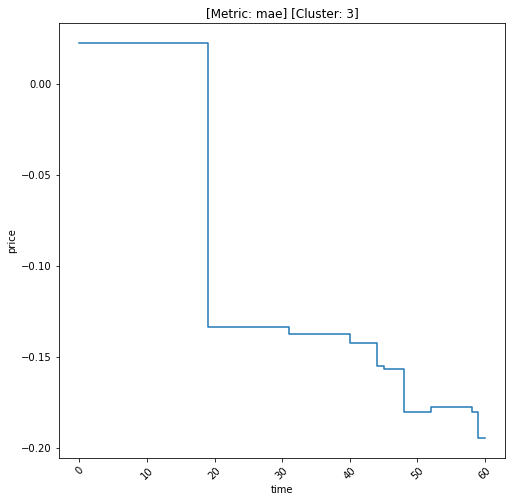

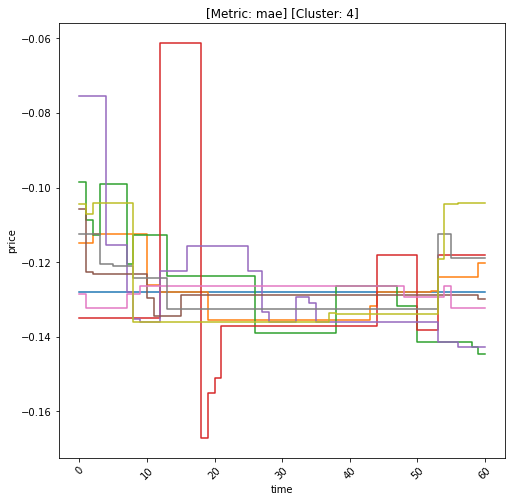

In [26]:
new_plat2_month = clusterize(plat2_month, num_means=5)
print()

for metric in metrics:
    print(f"{'-'*30} {metric} {'-'*30}")
    clustered_sessions(new_plat2_month, metric=metric, normalize=True, figsize=8)
    print()

#### Суточные торги: площадка 1

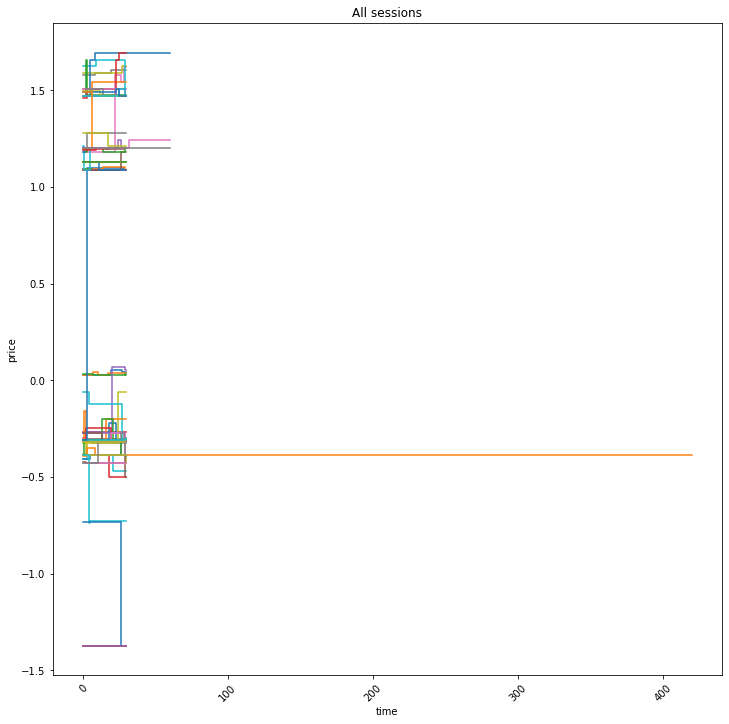

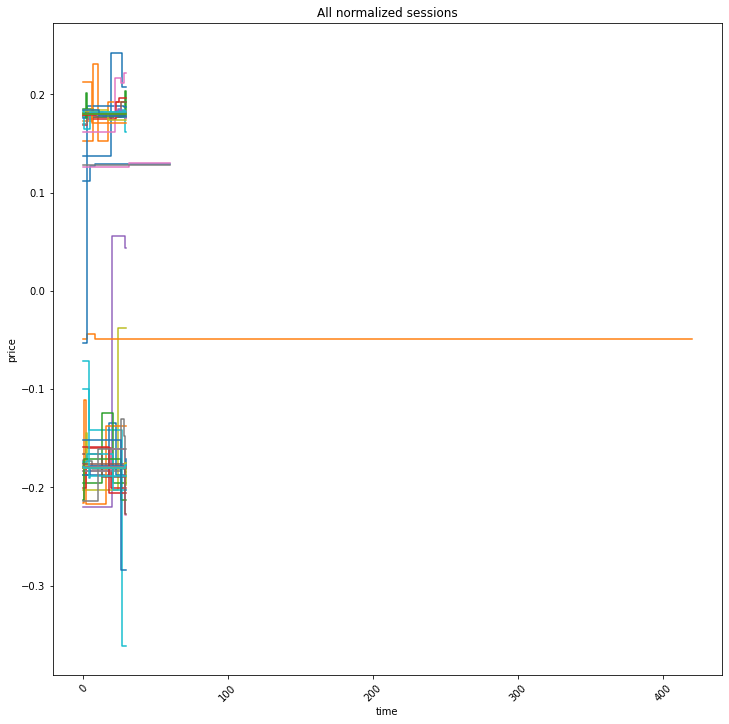

In [27]:
one_pic_all_binarized_sessions(plat1_day)

one_pic_all_binarized_sessions(plat1_day, normalize=True)

k-means trial 0
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration

------------------------------ dtw ------------------------------


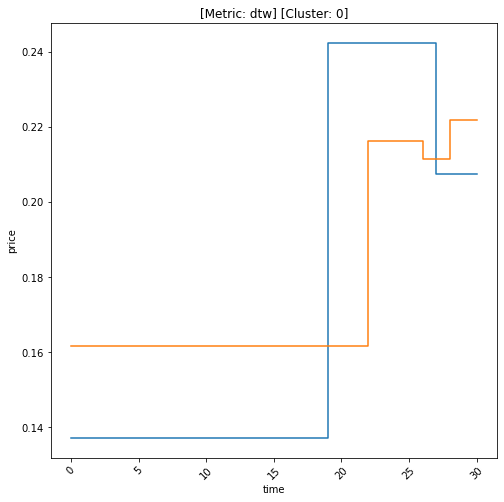

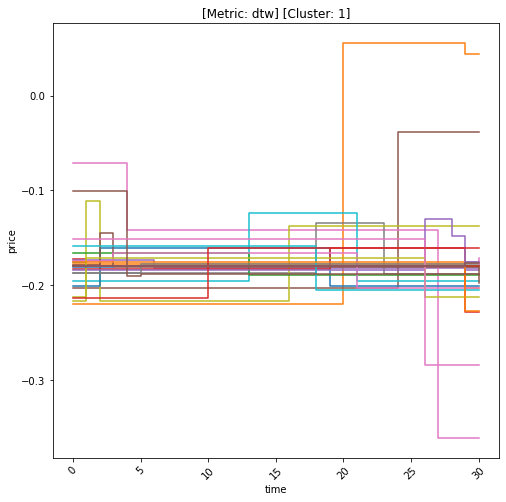

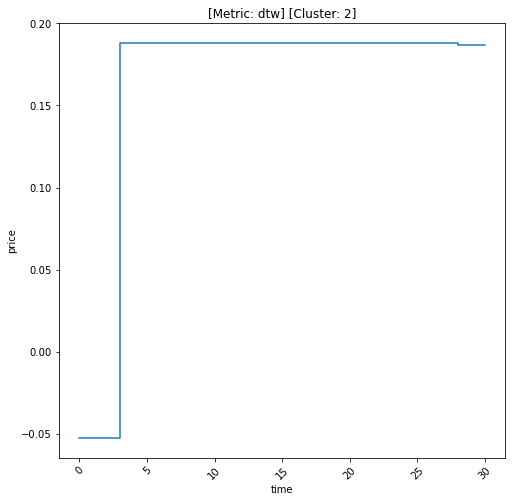

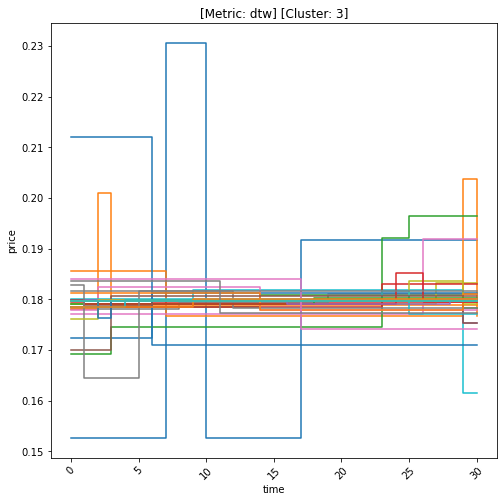


------------------------------ cos ------------------------------


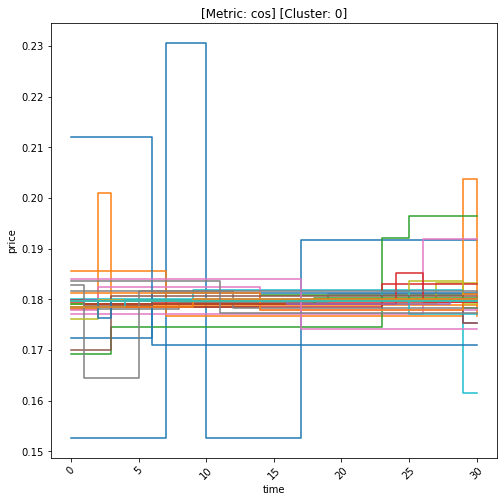

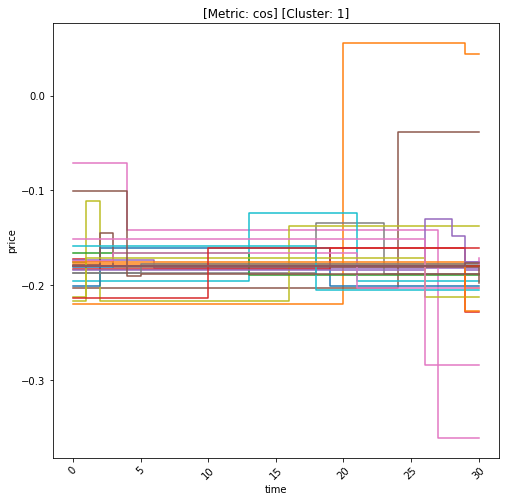

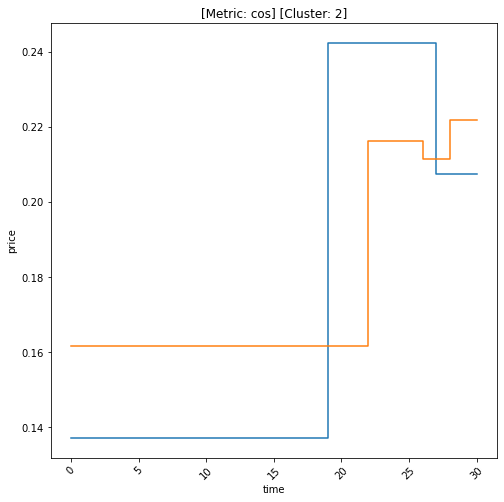

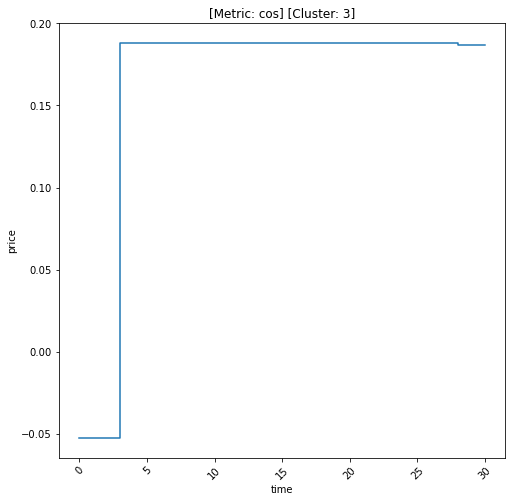


------------------------------ mae ------------------------------


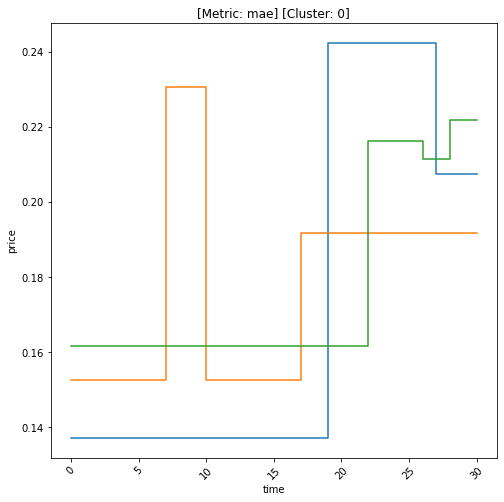

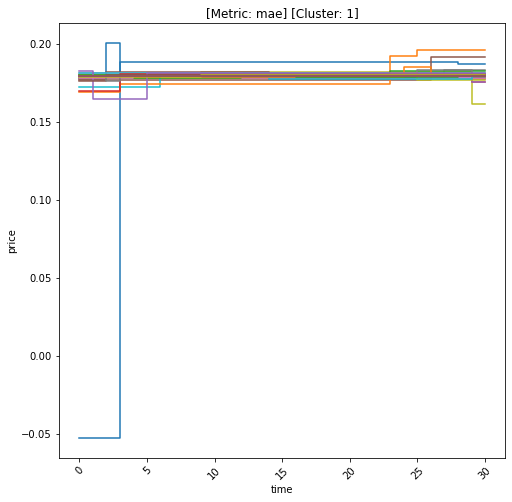

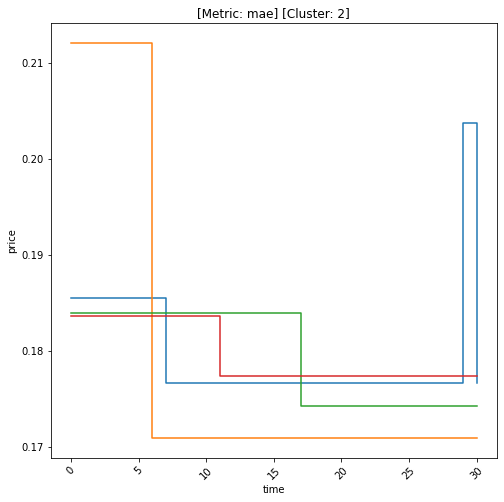

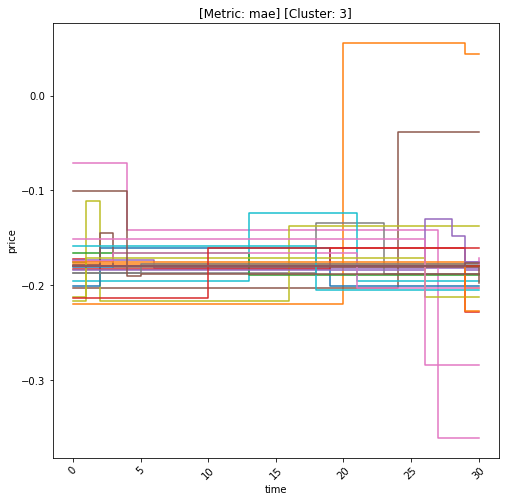

In [30]:
new_plat1_day = clusterize(plat1_day, num_means=4)
print()

for metric in metrics:
    print(f"{'-'*30} {metric} {'-'*30}")
    clustered_sessions(new_plat1_day, metric=metric, normalize=True, figsize=8)
    print()

#### Суточные торги: площадка 2

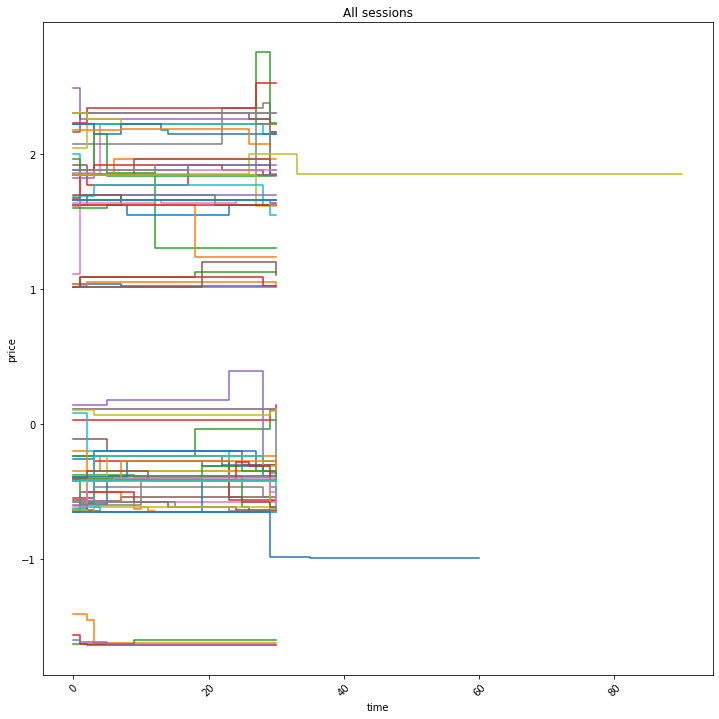

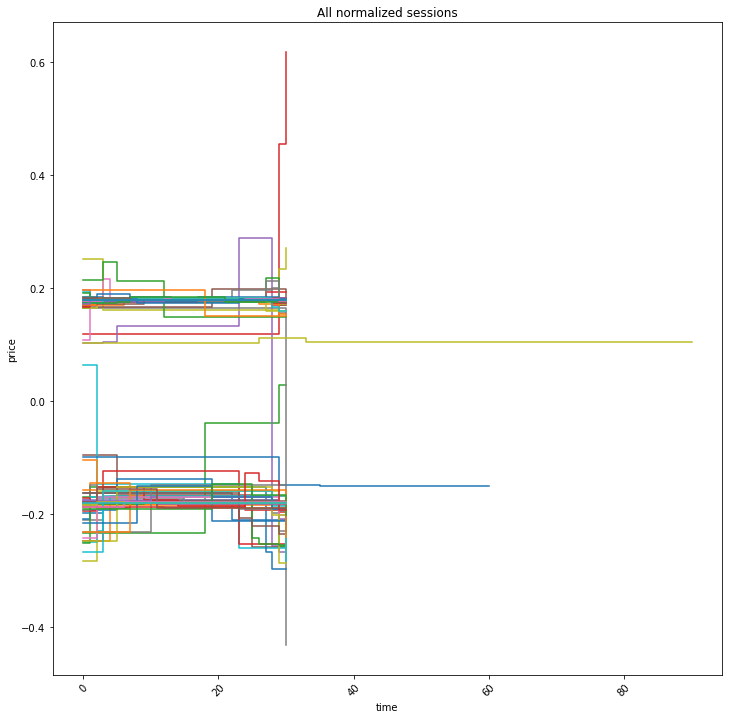

In [31]:
one_pic_all_binarized_sessions(plat2_day)

one_pic_all_binarized_sessions(plat2_day, normalize=True)

k-means trial 0
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration

------------------------------ dtw ------------------------------


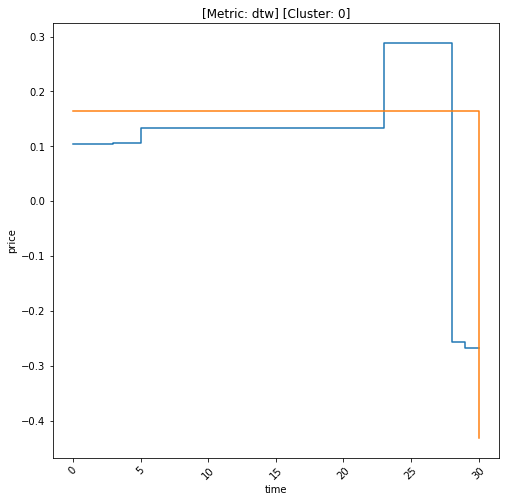

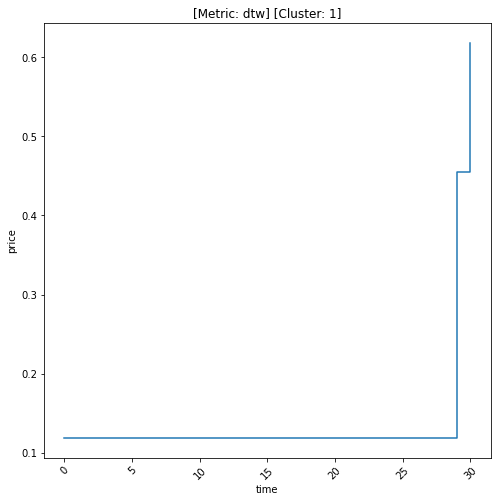

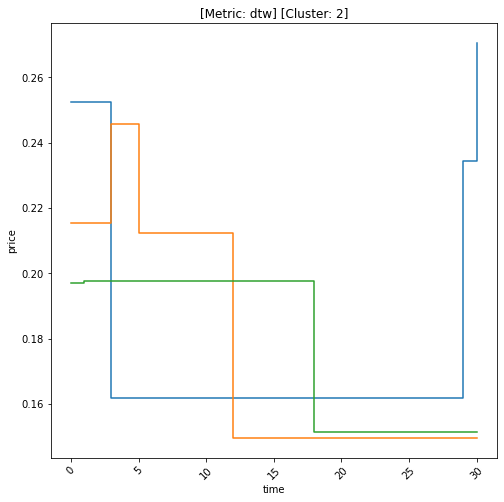

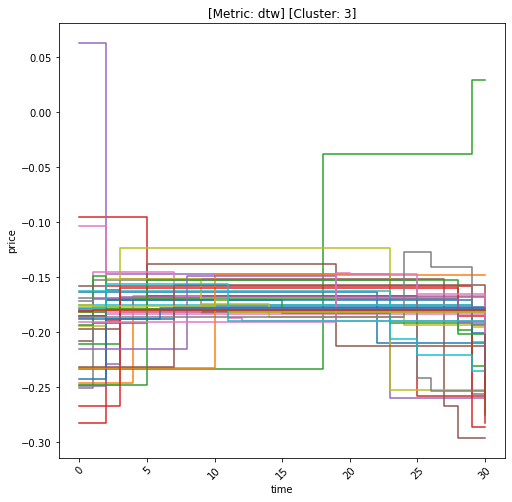

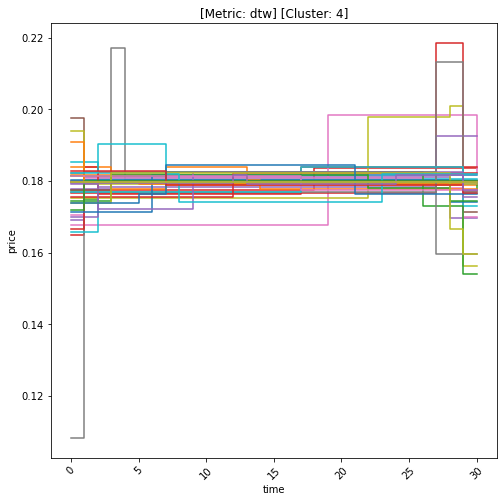


------------------------------ cos ------------------------------


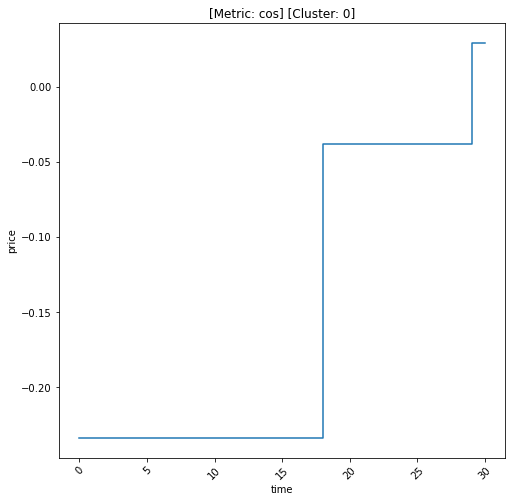

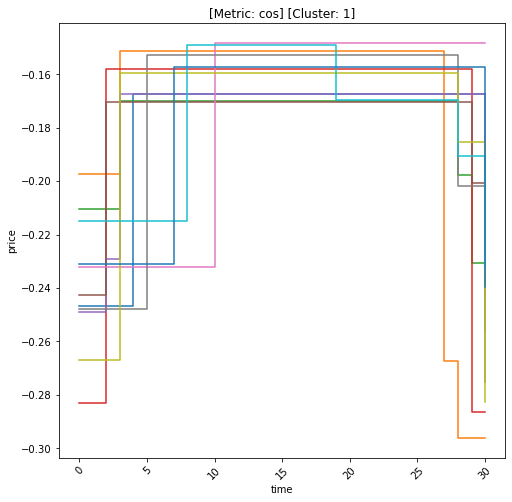

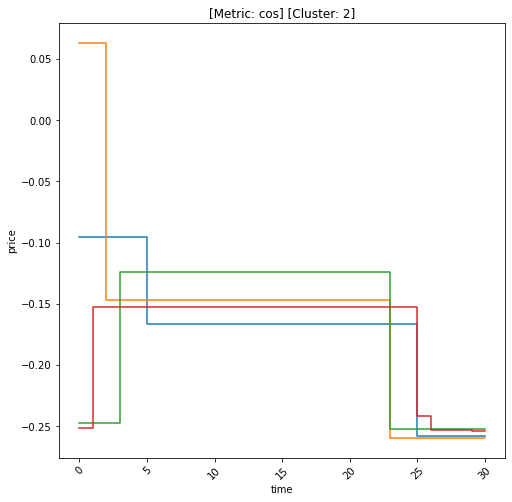

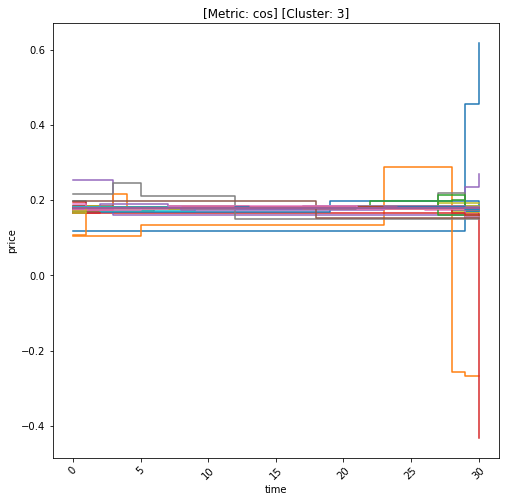

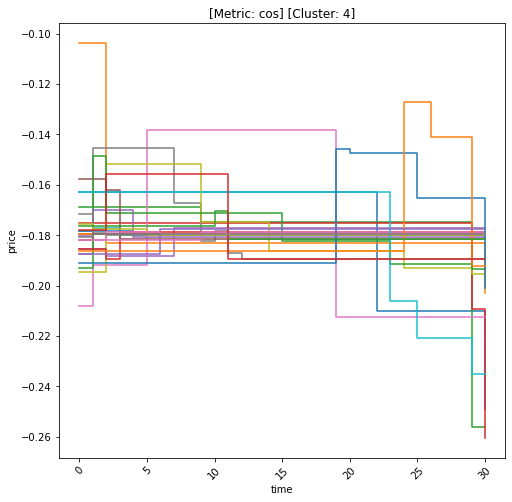


------------------------------ mae ------------------------------


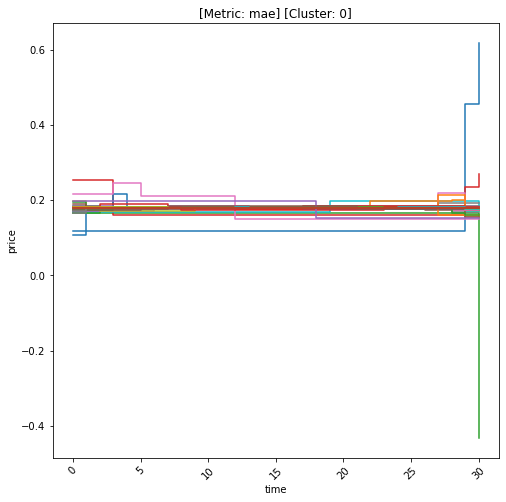

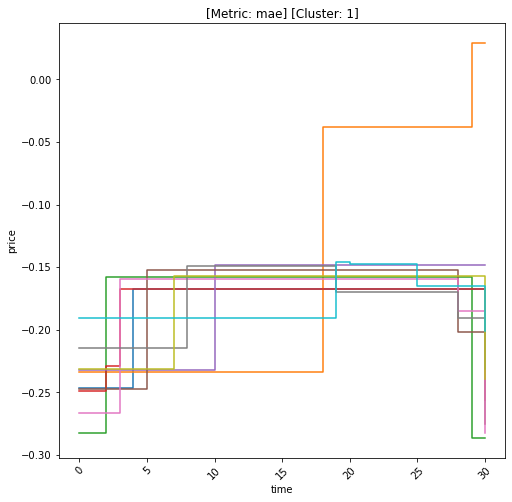

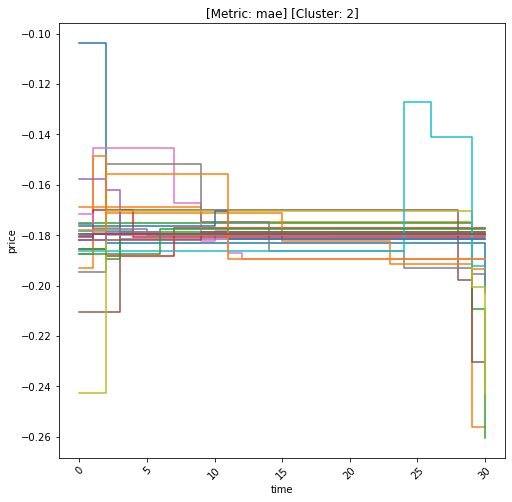

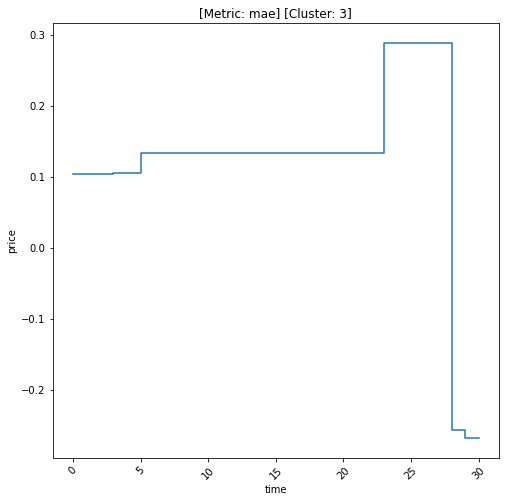

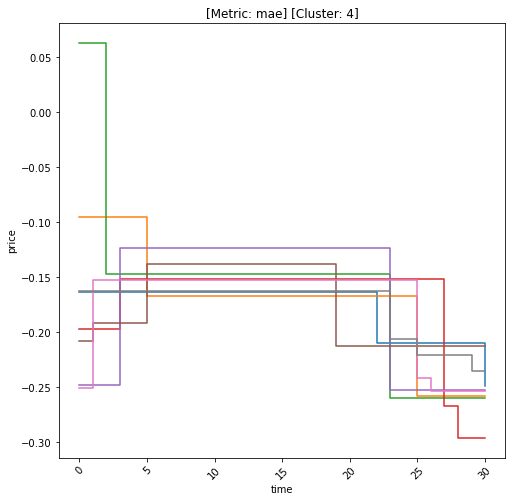

In [35]:
new_plat2_day = clusterize(plat2_day, num_means=5)
print()

for metric in metrics:
    print(f"{'-'*30} {metric} {'-'*30}")
    clustered_sessions(new_plat2_day, metric=metric, normalize=True, figsize=8)
    print()